In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tqdm

from IPython import display

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, tf.one_hot(train_labels,10))).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, use_bias=False, input_shape=(50,)))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())    

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

W1018 06:24:30.840538 139889456981824 base_layer.py:1814] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



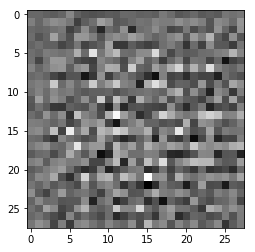

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 40])
labels = np.eye(10)[np.random.choice(10, 1)]
generated_image = generator(np.hstack((noise, labels)), training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__(name='')
        #filters1, filters2, filters3 = filters
        
        self.act = layers.LeakyReLU()
        self.drop = layers.Dropout(0.3)
        self.conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1])
        self.conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        
        self.dense1 = tf.keras.layers.Dense(128, self.act)
        self.dense2 = tf.keras.layers.Dense(1, tf.nn.sigmoid)
        
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        self.loss = tf.keras.losses.BinaryCrossentropy()
        
    def call(self, images, labels, training=False):
        
        x = self.conv1(images)
        x = self.act(x)
        x = self.drop(x, training=training)
        x = self.conv2(x)
        x = self.act(x)
        x = self.drop(x, training=training)
        
        x = tf.reshape(x, (images.shape[0], -1))
        x = tf.concat((x, labels), axis=1)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [15]:
discriminator = Discriminator()
decision = discriminator(generated_image, tf.constant(labels, dtype='float32'))
print (decision)

tf.Tensor([[0.4953285]], shape=(1, 1), dtype=float32)


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
a = (list(range(10)) + list(range(10)))
a.sort()
a

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]

In [21]:
EPOCHS = 100
noise_dim = 40
num_examples_to_generate = 20

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
labels_seed = tf.one_hot(tf.constant(np.array(a)),10)

In [22]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    labels_n = tf.one_hot(tf.constant(np.random.randint(10, size = (BATCH_SIZE,))), 10)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(tf.concat((noise, labels_n), axis=1), training=True)

        real_output = discriminator(images, labels, training=True)
        fake_output = discriminator(generated_images, labels_n, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def generate_and_save_images(model, epoch, test_input, test_labels):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(tf.concat((test_input, test_labels), axis=1))

  fig = plt.figure(figsize=(15,12))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('LGAN_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, labels_batch in tqdm.tqdm_notebook(dataset):
      train_step(image_batch, labels_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed, labels_seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, labels_seed)

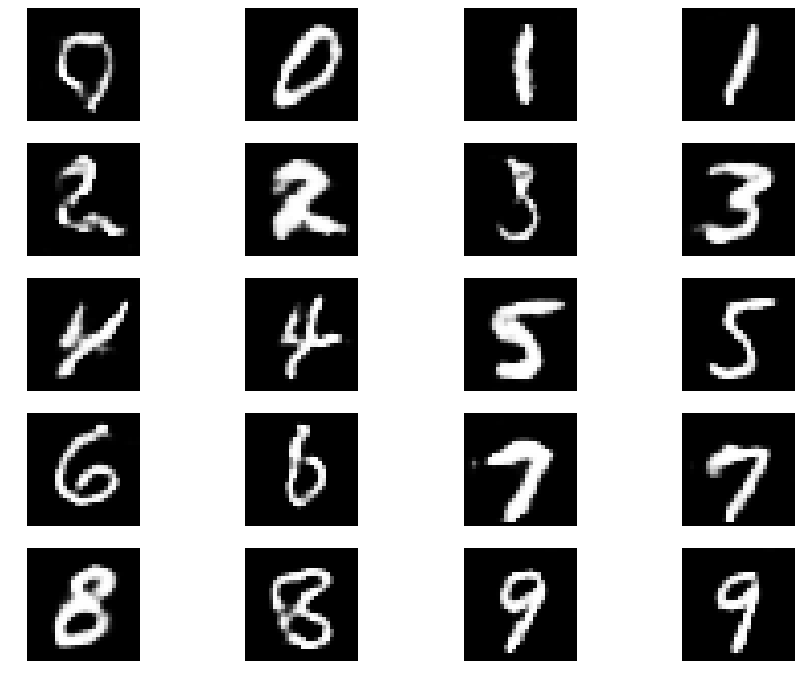

CPU times: user 1d 14h 28min 56s, sys: 15min 21s, total: 1d 14h 44min 17s
Wall time: 5h 14min 2s


In [27]:
%%time
train(train_dataset, EPOCHS)

In [28]:
anim_file = 'dclgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('LGAN_images/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    for _ in range(100):
        frame = 100*(i**0.5)
        if round(frame) > round(last):
          last = frame
        else:
          continue
        image = imageio.imread(filename)
        writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [31]:
def generate_and_show_images(model, epoch, test_input, test_labels):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(tf.concat((test_input, test_labels), axis=1), training=False)

  fig = plt.figure(figsize=(15,12))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

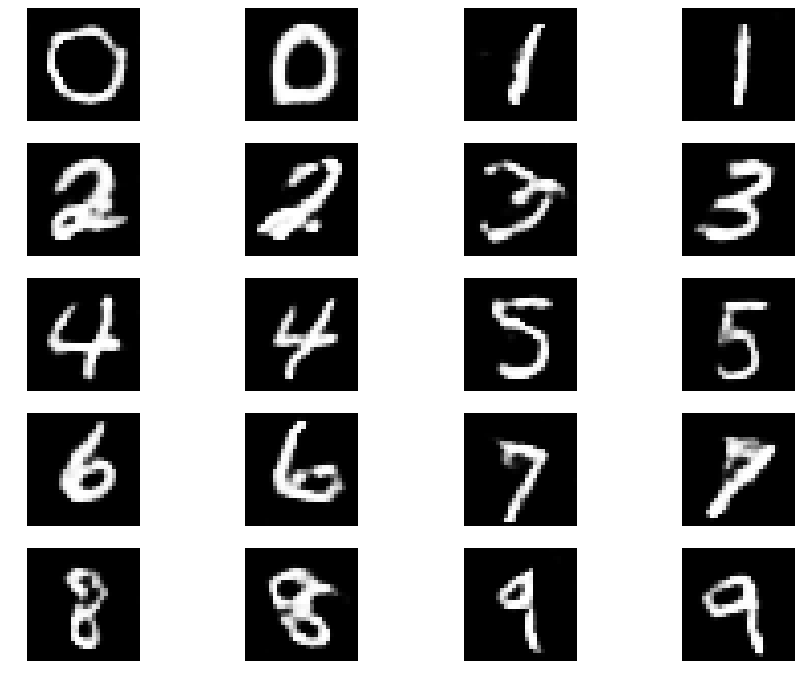

In [38]:
generate_and_show_images(generator, 0, tf.random.normal([20, 40]), labels_seed)